# Final Report - I'm Something of a Painter Myself

``Final_Report.ipynb``  
Katrina Wlson & Kona Glenn   
CSCI 349 Final Project  
Link to Kaggle competition: https://www.kaggle.com/competitions/gan-getting-started/overview  

In [1]:
# Get rid of pesky warnings
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import seaborn as sns
import pandas as pd
import os
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

# Visualization helper functions from Professor Stough
import sys
from vis_utils import *

2024-04-30 19:38:46.103108: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


---

## Introduction  
**What problem are we working on?**  
For the final project for CSCI 249, we decided to work on a Kaggle competition. This competition describes the following challenge: use generative adversarial networks to imitate the unique style of the famout artist Claude Monet. We will bring his style to various images, doing our best to recreate his certain 'je ne sais quoi'. Can we trick viewers into beleiving we've created real Monet paintings? That is the challenge!

**What are our goals with this project?**  
*What we want to learn:* This project will be a good opportunity to use Data Mining in a context we haven't explored yet: images. Though it is easy to compare two images visually, it will be interesting to learn statistical techniques to compare the similarity of images (SSIM!).

*Expected challenges:* We expect to run into a lot of libraries and functionality that are needed in order to perform analysis on images that are unfamilliar to us. Performing meaningful EDA on images will require us to be creative. We are curious on how to best quantify our results. For now, we hope to improve the SSIM values between the original painting, a photo of the location, and the generated image. 

*Overarching goal:* We want to learn more about classifying and creating images from a neural network as well as trying to create Monet like images from landscape photos. 

---

## Data
### What data are we using to understand the problem?
**From Kaggle:** For training data, we have 300 Monet paintings sized 256x256 in JPEG format and the same images sized 256x256 in TFRecord format. TFRecords are used to store sequences of binary records of TensorFlow data. Our model will generate 7028 Monet-like images from 7028 photos formatted the same way as the training data. 

**Our own ideas:** After working on this project for a couple weeks, we decided to take our own spin on the project by comparing photos of the locations Monet painted with the original paintings. We then will transform the photographs into a monet-ized version, that is hopefully more similar to the original painting! We have 7 paintings and their corresponding locations. 

Here are some sample paintings and photos from the Kaggle dataset. 

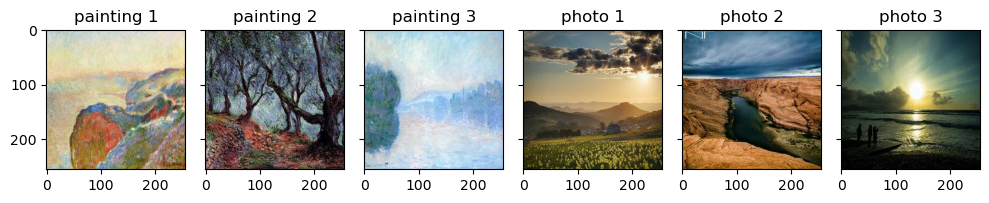

In [3]:
# Load in 3 paintings 
img_0 = plt.imread('data/monet_jpg/000c1e3bff.jpg')
img_1 = plt.imread('data/monet_jpg/011835cfbf.jpg')
img_2 = plt.imread('data/monet_jpg/0260d15306.jpg')

# Load in 3 photos 
photo_0 = plt.imread('data/photo_jpg/00068bc07f.jpg')
photo_1 = plt.imread('data/photo_jpg/000910d219.jpg')
photo_2 = plt.imread('data/photo_jpg/000ded5c41.jpg')

f, ax = plt.subplots(1,6,figsize=(10,2), sharex=True, sharey=True)

ax[0].imshow(img_0);
ax[0].set_title('painting 1')
ax[1].imshow(img_1);
ax[1].set_title('painting 2')
ax[2].imshow(img_2);
ax[2].set_title('painting 3')
ax[3].imshow(photo_0);
ax[3].set_title('photo 1')
ax[4].imshow(photo_1);
ax[4].set_title('photo 2')
ax[5].imshow(photo_2);
ax[5].set_title('photo 3')

plt.tight_layout()
plt.show()

Here are the paintings and photos of locations Monet painted.

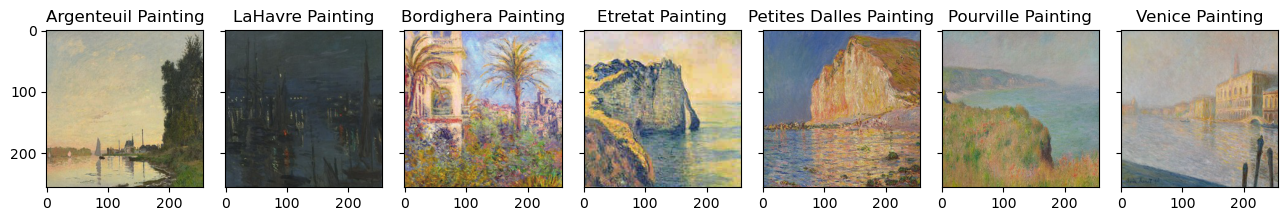

In [8]:
# Load in 7 paintings 
painting_arg = plt.imread('data/monet_loc.jpg/Argenteuil.jpg')
painting_lah = plt.imread('data/monet_loc.jpg/LaHavre.jpg')
painting_bor = plt.imread('data/monet_loc.jpg/painting-bordighera.jpg')
painting_etr = plt.imread('data/monet_loc.jpg/painting-etretat.jpg')
painting_dal = plt.imread('data/monet_loc.jpg/Petites-Dalles.jpg')
painting_pou = plt.imread('data/monet_loc.jpg/Pourville.jpg')
painting_ven = plt.imread('data/monet_loc.jpg/Venice.jpg')

f, ax = plt.subplots(1,7,figsize=(13,2), sharex=True, sharey=True)

ax[0].imshow(painting_arg);
ax[0].set_title('Argenteuil Painting')
ax[1].imshow(painting_lah);
ax[1].set_title('LaHavre Painting')
ax[2].imshow(painting_bor);
ax[2].set_title('Bordighera Painting')
ax[3].imshow(painting_etr);
ax[3].set_title('Etretat Painting')
ax[4].imshow(painting_dal);
ax[4].set_title('Petites Dalles Painting')
ax[5].imshow(painting_pou);
ax[5].set_title('Pourville Painting')
ax[6].imshow(painting_ven)
ax[6].set_title('Venice Painting')


plt.tight_layout()
plt.show()

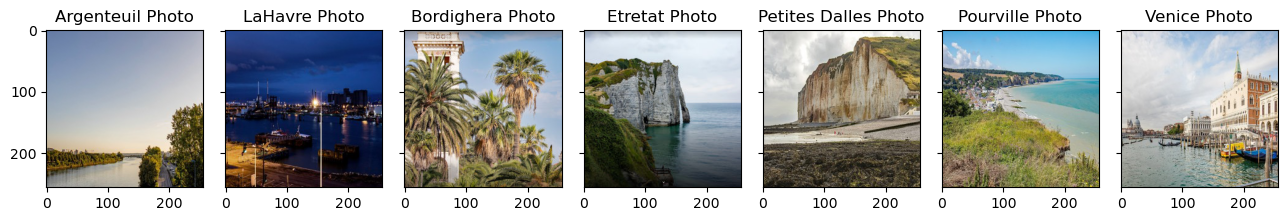

In [10]:
# Load in 7 locations
loc_arg = plt.imread('data/monet_ref_loc.jpg/Argenteuil.jpg')
loc_lah = plt.imread('data/monet_ref_loc.jpg/LaHavre.jpg')
loc_bor = plt.imread('data/monet_ref_loc.jpg/photo-bordighera.jpg')
loc_etr = plt.imread('data/monet_ref_loc.jpg/photo-etretat.jpg')
loc_dal = plt.imread('data/monet_ref_loc.jpg/Petites-Dalles.jpg')
loc_pou = plt.imread('data/monet_ref_loc.jpg/Pourville.jpg')
loc_ven = plt.imread('data/monet_ref_loc.jpg/Venice.jpg')

f, ax = plt.subplots(1,7,figsize=(13,2), sharex=True, sharey=True)

ax[0].imshow(loc_arg);
ax[0].set_title('Argenteuil Photo')
ax[1].imshow(loc_lah);
ax[1].set_title('LaHavre Photo')
ax[2].imshow(loc_bor);
ax[2].set_title('Bordighera Photo')
ax[3].imshow(loc_etr);
ax[3].set_title('Etretat Photo')
ax[4].imshow(loc_dal);
ax[4].set_title('Petites Dalles Photo')
ax[5].imshow(loc_pou);
ax[5].set_title('Pourville Photo')
ax[6].imshow(loc_ven)
ax[6].set_title('Venice Photo')

plt.tight_layout()
plt.show()

---

## Data Preparation  
**How are we preprocessing our data?**  
Since we are using images, data munging/cleaning looks a little different than how it has been in the previous labs. The images are already standardized to a 256x256 JPEG format, as is given by the Kaggle data set. To be extra thorough, we visually inspected all of the photos of paintings before running our model, to make sure there weren't any misformatted paintings. In tradititional data mining, it would be impossible to manually inspect all data entries but for images, we thought a quick once over would do no harm. Low and behold, we found 3 images that were questionable. 

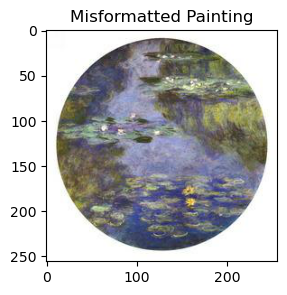

In [11]:
# Show the painting 
bad_painting_1 = plt.imread('data/bad-painting/c78b4fa3a9.jpg')

plt.figure(figsize=(4,3))
plt.imshow(bad_painting_1); # semicolon ; to suppress text display
plt.title("Misformatted Painting")
plt.show()

We decided to eliminate this image from the dataset, given that the white borders are not a part of the paintin and may skew the future models. 

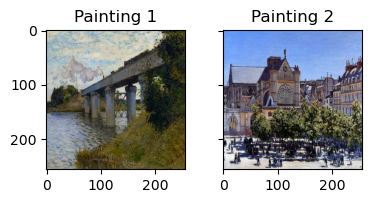

In [13]:
f, ax = plt.subplots(1,2,figsize=(4,2), sharex=True, sharey=True)

bad_painting_2 = plt.imread('data/monet_jpg/1a127acf4d.jpg')
bad_painting_3 = plt.imread('data/monet_jpg/815624563e.jpg')

ax[0].imshow(bad_painting_2);
ax[0].set_title('Painting 1')
ax[1].imshow(bad_painting_3);
ax[1].set_title('Painting 2')
plt.tight_layout()
plt.show()

For these images, we first thought they looked too much like real photos to be Monet paintings. But, upon further inspection and reverse image searchs on google, they were indeed Monet paintings. The low resolution of the photos of paintings definitely altered the quality, but we're glad that we double checked. All of the other photos of paintings seemed appropriate.

---

# EDA - Exploratory Data Analysis  


### RGB Pixel Distribution

To start, we thought it would be valuable to understand the differences in the distributions of pixels in both of our datasets: the paintings and the photos to be transformed.

In [14]:
'''
Function that averages the red, green, and blue values of 
pixels of every image in a folder.

'''
def extract_rgb_means(folder_path):

    # Initialize lists to store statistics
    red_means = []
    green_means = []
    blue_means = []

    red_medians = []
    green_medians = []
    blue_medians = []

    red_std = []
    green_std = []
    blue_std = []

    # Iterate through all image files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            # Construct the full path to the image
            image_path = os.path.join(folder_path, filename)
            
            # Load the image
            image = cv2.imread(image_path)
            
            if image is not None:
                # Convert BGR to RGB
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Extract individual color channels
                red_channel = image_rgb[:, :, 0]
                green_channel = image_rgb[:, :, 1]
                blue_channel = image_rgb[:, :, 2]
                
                # Calculate mean for each color channel
                r_mean = np.mean(red_channel)
                g_mean = np.mean(green_channel)
                b_mean = np.mean(blue_channel)

                # Calculate median for each color channel
                r_median = np.median(red_channel)
                g_median = np.median(green_channel)
                b_median = np.median(blue_channel)

                # Calculate the standard deviation for each color channel
                r_std = np.std(red_channel)
                g_std = np.std(green_channel)
                b_std = np.std(blue_channel)

                red_means.append(r_mean)
                green_means.append(g_mean)
                blue_means.append(b_mean)

                red_medians.append(r_median)
                green_medians.append(g_median)
                blue_medians.append(b_median)

                red_std.append(r_std)
                green_std.append(g_std)
                blue_std.append(b_std)


    # Create DataFrames for each color
    df_red = pd.DataFrame({"color": "red", "mean": red_means, "median": red_medians, "standard_deviation": red_std})
    df_green = pd.DataFrame({"color": "green", "mean": green_means, "median": green_medians, "standard_deviation": green_std})
    df_blue = pd.DataFrame({"color": "blue", "mean": blue_means, "median": blue_medians, "standard_deviation": blue_std})

    # Concatenate DataFrames
    df_means = pd.concat([df_red, df_green, df_blue], ignore_index=True)

    return df_means


Now, we visualize the distribution of pixels for the Monet JPG images and the landscape photos using a boxplot. Boxplots are a great way to visualize the distribution of a single variable. 

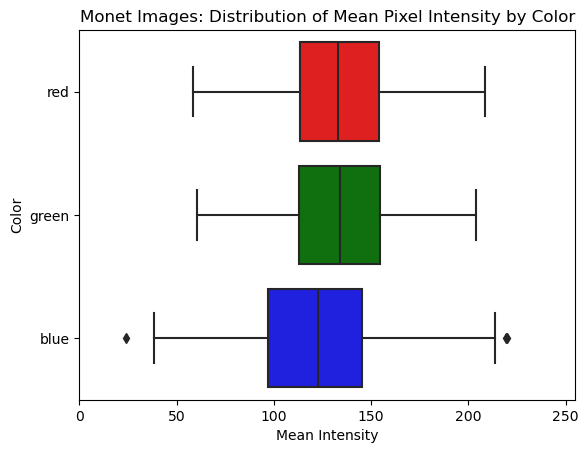

In [15]:
# Create visualization for Monet images
df_monet = extract_rgb_means('data/monet_jpg/')

# Plot boxplot
colors = {'red': 'red', 'green': 'green', 'blue': 'blue'}

sns.boxplot(data=df_monet, x="mean", y="color", palette=colors)
plt.title('Monet Images: Distribution of Mean Pixel Intensity by Color')
plt.xlabel('Mean Intensity')
plt.ylabel('Color')
plt.xlim(0, 255)
plt.show()

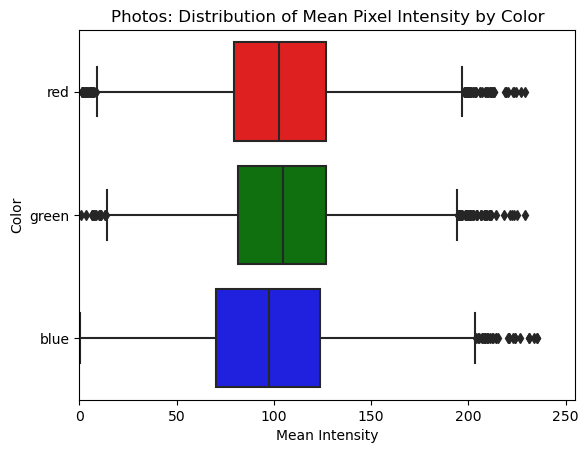

In [16]:
# Create visualization for Monet images
df_photo = extract_rgb_means('data/photo_jpg/')

# Plot boxplot
colors = {'red': 'red', 'green': 'green', 'blue': 'blue'}

sns.boxplot(data=df_photo, x="mean", y="color", palette=colors)
plt.title('Photos: Distribution of Mean Pixel Intensity by Color')
plt.xlabel('Mean Intensity')
plt.ylabel('Color')
plt.xlim(0, 255)
plt.show()

**Understanding the boxplots**  
Based on the boxplots, there are a lot more outliers in the photos dataset compared to the paintings dataset. The median RBG values for photos are typically 20ish pixels lower than the RBG values for the paintings. But, there is a significant amount of overlap between the boxes created by the Q1 and Q3 values for each color when comparing the photos to the paintings. This means that there isn't a huge significant difference between the RGB values of both datasets, but Monet paintings tend to have higher RGB values, which visually means lighter or more "pastel" colors. Monet paintings tend to have less shadows than real images, which perhaps also contributes to the higher distribution of RGB values for the paintings.

We can also show plots of the RGB values for Monet paintings and photos using histograms.

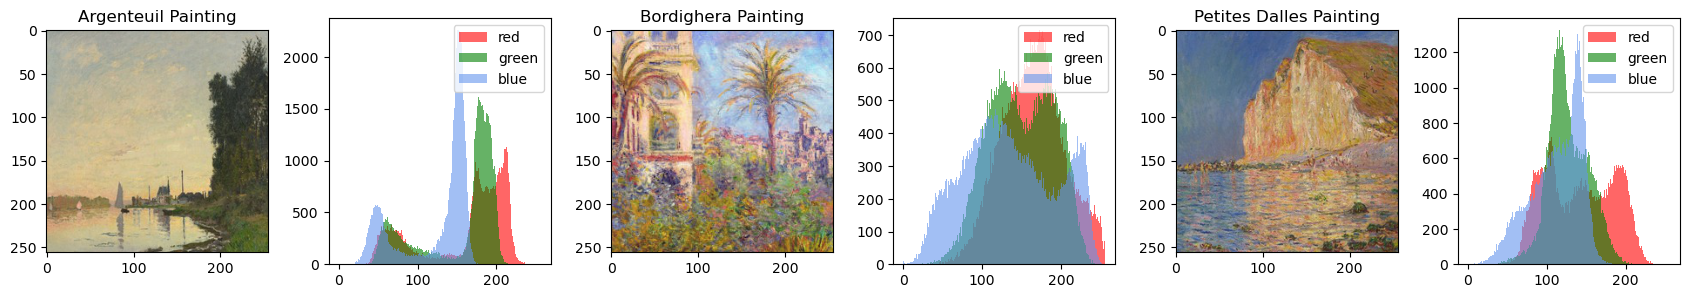

In [27]:
f, axarr = plt.subplots(1,6, figsize=(17, 3))

# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html
axarr[0].imshow(painting_arg) 
axarr[0].set_title('Argenteuil Painting')

axarr[1].hist(painting_arg[...,0].ravel(), bins=np.arange(257), alpha = .6, label = 'red', color = 'r');
axarr[1].hist(painting_arg[...,1].ravel(), bins=np.arange(257), alpha = .6, label = 'green', color = 'g');
axarr[1].hist(painting_arg[...,2].ravel(), bins=np.arange(257), alpha = .6, label = 'blue', color = 'cornflowerblue');
axarr[1].legend(loc = 'upper right');

axarr[2].imshow(painting_bor) 
axarr[2].set_title('Bordighera Painting')

axarr[3].hist(painting_bor[...,0].ravel(), bins=np.arange(257), alpha = .6, label = 'red', color = 'r');
axarr[3].hist(painting_bor[...,1].ravel(), bins=np.arange(257), alpha = .6, label = 'green', color = 'g');
axarr[3].hist(painting_bor[...,2].ravel(), bins=np.arange(257), alpha = .6, label = 'blue', color = 'cornflowerblue');
axarr[3].legend(loc = 'upper right');

axarr[4].imshow(painting_dal) 
axarr[4].set_title('Petites Dalles Painting')

axarr[5].hist(painting_dal[...,0].ravel(), bins=np.arange(257), alpha = .6, label = 'red', color = 'r');
axarr[5].hist(painting_dal[...,1].ravel(), bins=np.arange(257), alpha = .6, label = 'green', color = 'g');
axarr[5].hist(painting_dal[...,2].ravel(), bins=np.arange(257), alpha = .6, label = 'blue', color = 'cornflowerblue');
axarr[5].legend(loc = 'upper right');

plt.tight_layout()
plt.show()

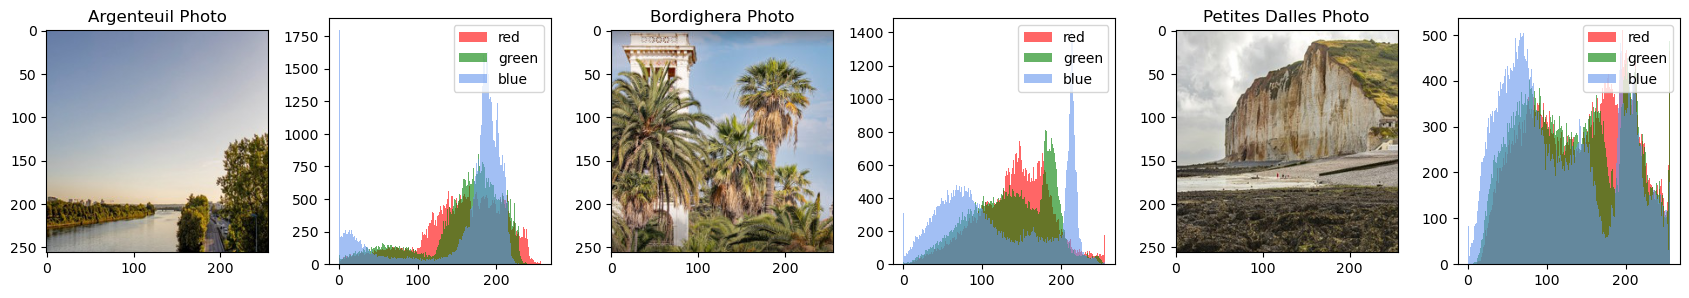

In [26]:
f, axarr = plt.subplots(1,6, figsize=(17, 3))

# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html
axarr[0].imshow(loc_arg) 
axarr[0].set_title('Argenteuil Photo')

axarr[1].hist(loc_arg[...,0].ravel(), bins=np.arange(257), alpha = .6, label = 'red', color = 'r');
axarr[1].hist(loc_arg[...,1].ravel(), bins=np.arange(257), alpha = .6, label = 'green', color = 'g');
axarr[1].hist(loc_arg[...,2].ravel(), bins=np.arange(257), alpha = .6, label = 'blue', color = 'cornflowerblue');
axarr[1].legend(loc = 'upper right');

axarr[2].imshow(loc_bor) 
axarr[2].set_title('Bordighera Photo')

axarr[3].hist(loc_bor[...,0].ravel(), bins=np.arange(257), alpha = .6, label = 'red', color = 'r');
axarr[3].hist(loc_bor[...,1].ravel(), bins=np.arange(257), alpha = .6, label = 'green', color = 'g');
axarr[3].hist(loc_bor[...,2].ravel(), bins=np.arange(257), alpha = .6, label = 'blue', color = 'cornflowerblue');
axarr[3].legend(loc = 'upper right');

axarr[4].imshow(loc_dal) 
axarr[4].set_title('Petites Dalles Photo')

axarr[5].hist(loc_dal[...,0].ravel(), bins=np.arange(257), alpha = .6, label = 'red', color = 'r');
axarr[5].hist(loc_dal[...,1].ravel(), bins=np.arange(257), alpha = .6, label = 'green', color = 'g');
axarr[5].hist(loc_dal[...,2].ravel(), bins=np.arange(257), alpha = .6, label = 'blue', color = 'cornflowerblue');
axarr[5].legend(loc = 'upper right');

plt.tight_layout()
plt.show()

**Understanding the RGB historgrams**  
Though there are only 3 of the paintings and 3 of the photos, we can notice that the pixels are on average lighter for the Petites Dalles painting than the photo, which is unsurprising given the mass of seaweed at the bottom of the photo. These histograms aren't super helpful, but interesting to see that we can quantify the distribution of red, green, and blue from an image.

### Summary Statistcs  
We calculated the means, medians, and standard deviations for both image datasets.

In [17]:
# Create data frames for different color channels
# Paintings
df_r_monet = df_monet[df_monet["color"] == "red"]
df_g_monet = df_monet[df_monet["color"] == "green"]
df_b_monet = df_monet[df_monet["color"] == "blue"]

# Photos
df_r_photo = df_photo[df_photo["color"] == "red"]
df_g_photo = df_photo[df_photo["color"] == "green"]
df_b_photo = df_photo[df_photo["color"] == "blue"]

In [18]:
# Means for Monet Paintings
mean_r = df_r_monet["mean"].mean()
mean_g = df_g_monet["mean"].mean()
mean_b = df_b_monet["mean"].mean()

print(f"The mean pixel value of red in Monet paintings: {mean_r:.2f}")
print(f"The mean pixel value of green in Monet paintings: {mean_g:.2f}")
print(f"The mean pixel value of blue in Monet paintings: {mean_b:.2f}")


The mean pixel value of red in Monet paintings: 132.87
The mean pixel value of green in Monet paintings: 133.63
The mean pixel value of blue in Monet paintings: 121.43


In [19]:
# Means for photos
mean_r = df_r_photo["mean"].mean()
mean_g = df_g_photo["mean"].mean()
mean_b = df_b_photo["mean"].mean()

print(f"The mean pixel value of red in photos: {mean_r:.2f}")
print(f"The mean pixel value of green in photos: {mean_g:.2f}")
print(f"The mean pixel value of blue in photots: {mean_b:.2f}")

The mean pixel value of red in photos: 102.97
The mean pixel value of green in photos: 104.19
The mean pixel value of blue in photots: 97.93


In [20]:
# Medians for Monet Paintings
median_r = df_r_monet["median"].mean()
median_g = df_g_monet["median"].mean()
median_b = df_b_monet["median"].mean()

print(f"The median pixel value of red in Monet paintings: {median_r:.2f}")
print(f"The median pixel value of green in Monet paintings: {median_g:.2f}")
print(f"The median pixel value of blue in Monet paintings: {median_b:.2f}")

The median pixel value of red in Monet paintings: 135.30
The median pixel value of green in Monet paintings: 135.98
The median pixel value of blue in Monet paintings: 121.55


In [21]:
# Medians for photos
median_r = df_r_photo["median"].mean()
median_g = df_g_photo["median"].mean()
median_b = df_b_photo["median"].mean()

print(f"The median pixel value of red in photos: {median_r:.2f}")
print(f"The median pixel value of green in photos: {median_g:.2f}")
print(f"The median pixel value of blue in photots: {median_b:.2f}")

The median pixel value of red in photos: 97.78
The median pixel value of green in photos: 101.46
The median pixel value of blue in photots: 95.24


In [22]:
# Standard deviations for Monet
std_r = df_r_monet["standard_deviation"].mean()
std_g = df_g_monet["standard_deviation"].mean()
std_b = df_b_monet["standard_deviation"].mean()

print(f"The standard deviation of pixel value of red in Monet paintings: {std_r:.2f}")
print(f"The standard deviation of pixel value of green in Monet paintings: {std_g:.2f}")
print(f"The standard deviation of pixel value of blue in Monet paintings: {std_b:.2f}")

The standard deviation of pixel value of red in Monet paintings: 48.67
The standard deviation of pixel value of green in Monet paintings: 46.37
The standard deviation of pixel value of blue in Monet paintings: 49.45


In [23]:
# Standard deviations for photos
std_r = df_r_photo["standard_deviation"].mean()
std_g = df_g_photo["standard_deviation"].mean()
std_b = df_b_photo["standard_deviation"].mean()

print(f"The standard deviation of pixel value of red in photos: {std_r:.2f}")
print(f"The standard deviation of pixel value of green in photos: {std_g:.2f}")
print(f"The standard deviation of pixel value of blue in photots: {std_b:.2f}")

The standard deviation of pixel value of red in photos: 56.58
The standard deviation of pixel value of green in photos: 51.70
The standard deviation of pixel value of blue in photots: 56.04


**Understanding the summary statistics**  
*Means*:  For all three color channels, the Monet Paintings have on average a higher mean pixel value (by about 30), implying lighter colors than the photos, as was shown in the boxplots.   
*Medians*: Similar to the means, the Monet Paintings have a higher medain pixel value.  
*Standard Deviation*: There are smaller standard deviations for the RGB channels for the Monet Paintings compared to the photos. This implies that there is less variability in color for the Monet Paintings than for the photos. This is interesting! Monet's impressionist style emphasizes light over the specific colors of the real-life scene he is depicting, leading to hues with less variations. Photos, on the other hand, captures a lot more detail in color than a painting.  

## K-means Clustering  
Here we do k-means clustering on an image to get representative colors for the image. We will compare Monet Paintings to photos of the locations Monet painted using image reconstruction. 

*From Professor Stough's ``demo_kmeans_image.ipynb`` in https://github.com/joshuastough/imageprocessing*

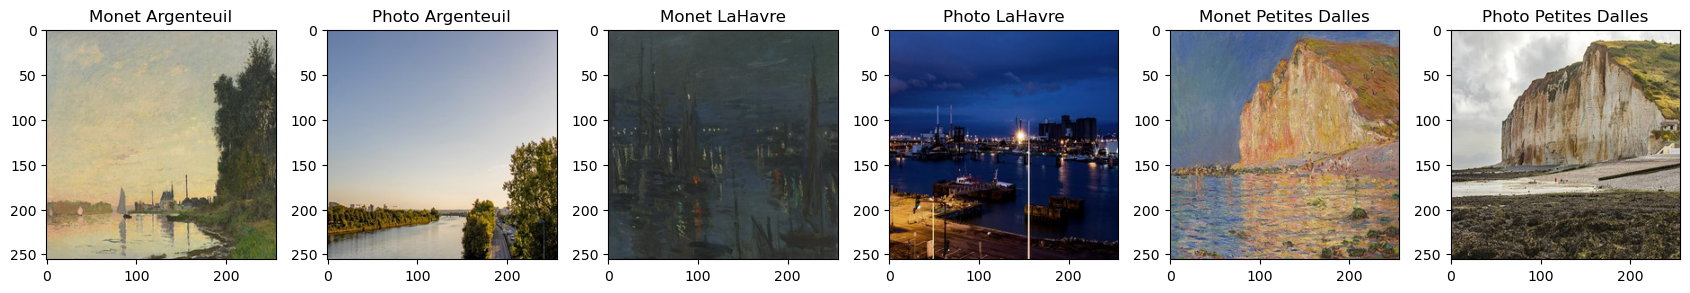

In [29]:
# Load in photos and paintings
painting_arg = plt.imread('data/monet_loc.jpg/Argenteuil.jpg')
photo_arg = plt.imread('data/monet_ref_loc.jpg/Argenteuil.jpg')

painting_lahav = plt.imread('data/monet_loc.jpg/LaHavre.jpg')
photo_lahav = plt.imread('data/monet_ref_loc.jpg/LaHavre.jpg')

painting_petite = plt.imread('data/monet_loc.jpg/Petites-Dalles.jpg')
photo_petite = plt.imread('data/monet_ref_loc.jpg/Petites-Dalles.jpg')

# Show the paintings and the photos 
f, axarr = plt.subplots(1,6, figsize=(17, 3))

axarr[0].imshow(painting_arg) 
axarr[0].set_title('Monet Argenteuil')

axarr[1].imshow(photo_arg) 
axarr[1].set_title('Photo Argenteuil')

axarr[2].imshow(painting_lahav) 
axarr[2].set_title('Monet LaHavre')

axarr[3].imshow(photo_lahav) 
axarr[3].set_title('Photo LaHavre')

axarr[4].imshow(painting_petite)
axarr[4].set_title('Monet Petites Dalles')

axarr[5].imshow(photo_petite) 
axarr[5].set_title('Photo Petites Dalles')

plt.tight_layout()
plt.show()

In [30]:
# Our functions to generate k means for images
K = 16
MAXITER = 20
NUMPOINTS = 100

# For fun: Let's pick some random (and good) cluster colors
clusterColors = np.random.rand(K, 3) # Picking random colors for each cluster.
varsSoFar = np.var(clusterColors, axis=0) # Should be 1 x 2 of the variance of each column.

for i in range(3*K):
    tempColors = np.random.rand(K, 3) #Picking K random colors
    vartemp = np.var(tempColors, axis=0)
    if np.all(vartemp > varsSoFar):
        clusterColors = tempColors
        varsSoFar = vartemp

# clusterColors

def color_kmeans(image, K):
    # K-means: initialization
    # pick K initial cluster centers.
    # whichinit = random.randint(0, len(X), size=(K,)) # Could generate repeats.
    X_image = np.stack([image[...,i].ravel() for i in range(3)]).T

    whichinit = np.random.choice(len(X_image), size=K, replace=False)
    CC = X_image[whichinit, :].copy() # Cluster Centers

    CC_init = CC.copy()

    ''' Main Expectation-Maximization loop
    Assign a cluster to each point, then recompute the clusters based on that assignment
    K-means: compute: for every data point determine which center is closest.
    Need some magic function that computes the distance between every row of X
    (the points) and every row of CC (the clusters).
    Basically, we assign a cluster to each point, and then
    recompute the clusters based on that assignment.'''
    
    for i in range(MAXITER):
        D = cdist(X_image, CC, 'euclidean')
        # D should be NUMPOINTS x K

        whichCluster = np.argmin(D, axis=1) # NUMPOINTS x 1 of which center was closest

        # K-means: recompute the cluster centers as the mean of the data in each cluster
        for c in range(K):
            if np.any(whichCluster == c):
                CC[c,:] = np.mean(X_image[whichCluster == c, :], axis=0) # average of just those that were closest to c.
    return X_image, CC, CC_init, whichCluster



Let's visualize the clustering for the Argenteuil photo and painting. 

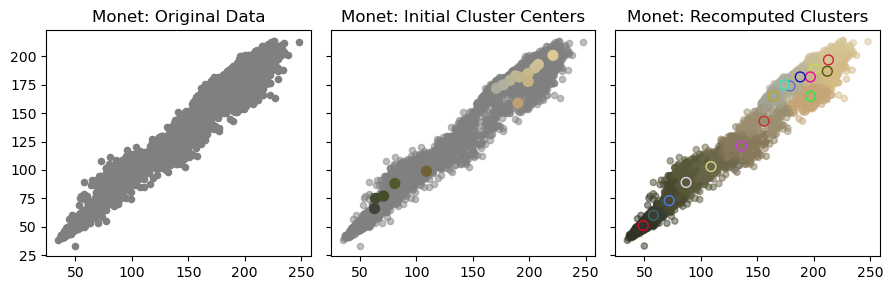

In [32]:
# Doing this on a big image, don't want to scatter 100Ks of points, really slow.
X_agr_monet, CC_agr_monet, CC_init_agr_monet, whichCluster_agr_monet = color_kmeans(painting_arg, 16)

rands = np.sort(np.random.choice(len(X_agr_monet), size=500*K, replace=False))

f, ax = plt.subplots(1,3, figsize=(9,3), sharex=True, sharey=True)
ax[0].scatter(X_agr_monet[rands,0], X_agr_monet[rands,1], c='gray', s=20)
ax[0].set_title('Monet: Original Data')


ax[1].scatter(X_agr_monet[rands,0], X_agr_monet[rands,1], c='gray', alpha=.5, s=20)
ax[1].scatter(CC_init_agr_monet[:,0], CC_init_agr_monet[:,1], c=CC_init_agr_monet/255, s=50)
ax[1].set_title('Monet: Initial Cluster Centers')


pointColors = CC_agr_monet[whichCluster_agr_monet[rands], :]
clusterEdgeColors = 1 - clusterColors # for contrast, make the cluster center edges opposite.
# clusterEdgeColors = 1 - CC/255 # for contrast, make the cluster center edges opposite.

ax[2].scatter(X_agr_monet[rands,0], X_agr_monet[rands,1], c=pointColors/255, alpha=.5, s=20)
ax[2].scatter(CC_agr_monet[:,0], CC_agr_monet[:,1], c=CC_agr_monet/255, edgecolors=clusterEdgeColors, s=50)
ax[2].set_title('Monet: Recomputed Clusters')

plt.tight_layout()
plt.show()

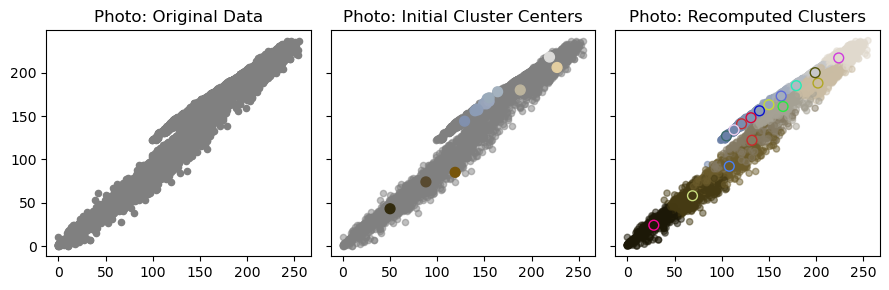

In [34]:
# Repeat with the photograph
X_agr_photo, CC_agr_photo, CC_init_agr_photo, whichCluster_agr_photo = color_kmeans(photo_arg, K)

rands = np.sort(np.random.choice(len(X_agr_photo), size=500*K, replace=False))

f, ax = plt.subplots(1,3, figsize=(9,3), sharex=True, sharey=True)
ax[0].scatter(X_agr_photo[rands,0], X_agr_photo[rands,1], c='gray', s=20)
ax[0].set_title('Photo: Original Data')


ax[1].scatter(X_agr_photo[rands,0], X_agr_photo[rands,1], c='gray', alpha=.5, s=20)
ax[1].scatter(CC_init_agr_photo[:,0], CC_init_agr_photo[:,1], c=CC_init_agr_photo/255, s=50)
ax[1].set_title('Photo: Initial Cluster Centers')


pointColors = CC_agr_photo[whichCluster_agr_photo[rands], :]
clusterEdgeColors = 1 - clusterColors # for contrast, make the cluster center edges opposite.
# clusterEdgeColors = 1 - CC/255 # for contrast, make the cluster center edges opposite.

ax[2].scatter(X_agr_photo[rands,0], X_agr_photo[rands,1], c=pointColors/255, alpha=.5, s=20)
ax[2].scatter(CC_agr_photo[:,0], CC_agr_photo[:,1], c=CC_agr_photo/255, edgecolors=clusterEdgeColors, s=50)
ax[2].set_title('Photo: Recomputed Clusters')

plt.tight_layout()
plt.show()

**Understanding the clustering**  
For the photo, we notice a lot of clusters closer together in the blue and white hues. The clusters are more evenly distributed in the painting. Monet's brushstrokes depict a less smooth vison of a sunset, perhaps leading to a more even distribution of hues in the clustering.

Now, let's reconstruct the paintings and photos using clustering. We will also visualize the clustering using a 2D image, now plotting 100 color values that were randomly chosen.

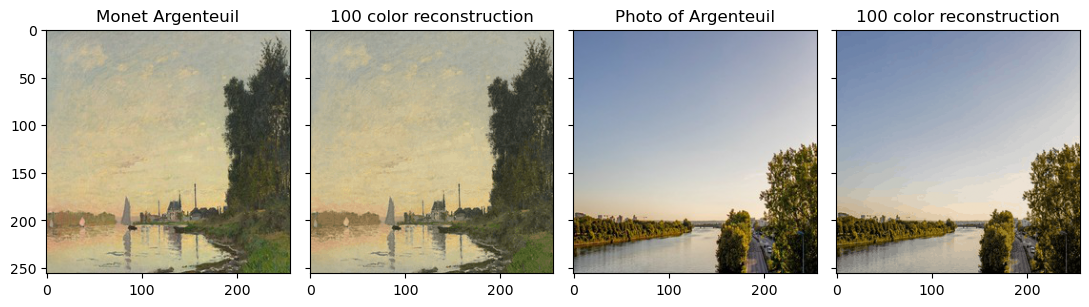

In [41]:
X_agr_monet_100, CC_agr_monet_100, CC_init_agr_monet_100, whichCluster_agr_monet_100 = color_kmeans(painting_arg, 100)
X_agr_photo_100, CC_agr_photo_100, CC_init_agr_photo_100, whichCluster_agr_photo_100 = color_kmeans(photo_arg, 100)

f, ax = plt.subplots(1,4, figsize=(11,3), sharex=True, sharey=True)

ax[0].imshow(painting_arg/255)
ax[0].set_title('Monet Argenteuil')

# Reconstructed Image.
Ir_arg_monet_100 = np.reshape(CC_agr_monet_100[whichCluster_agr_monet_100,:], painting_arg.shape)
ax[1].imshow(Ir_arg_monet_100/255) # Because it's floating point.
ax[1].set_title('{} color reconstruction'.format(K))

ax[2].imshow(photo_arg/255)
ax[2].set_title('Photo of Argenteuil')

# Reconstructed Image.
Ir_arg_photo_100 = np.reshape(CC_agr_photo_100[whichCluster_agr_photo_100,:], photo_arg.shape)
ax[3].imshow(Ir_arg_photo_100/255) # Because it's floating point.
ax[3].set_title('{} color reconstruction'.format(K))

plt.tight_layout()
plt.show()

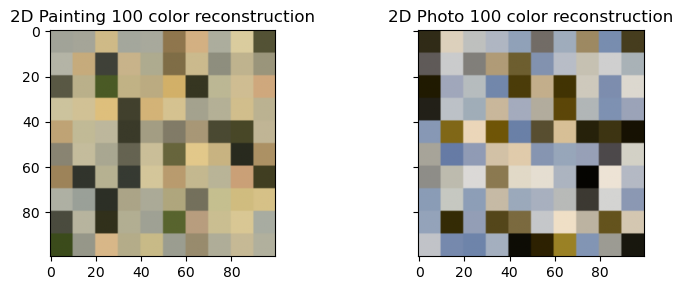

In [42]:
def transform_image(image, CC):
    for i in range(10):
        for j in range(10):

            image[i*10:i*10 + 10, j*10:j*10 + 10, :] = np.array(CC[10*i + j])
    return image

f, ax = plt.subplots(1,2, figsize=(8,3), sharex=True, sharey=True)

arg_painting_100 = np.zeros((100, 100, 3))
arg_photo_100 = np.zeros((100, 100, 3))

arg_painting_100 = transform_image(arg_painting_100, CC_agr_monet_100)
arg_photo_100 = transform_image(arg_photo_100, CC_agr_photo_100)

ax[0].imshow(arg_painting_100/255)
ax[0].set_title('2D Painting {} color reconstruction'.format(K))

ax[1].imshow(arg_photo_100/255)
ax[1].set_title('2D Photo {} color reconstruction'.format(K))

# plt.figure()
# plt.imshow(test_img/255)
plt.tight_layout()
plt.show()

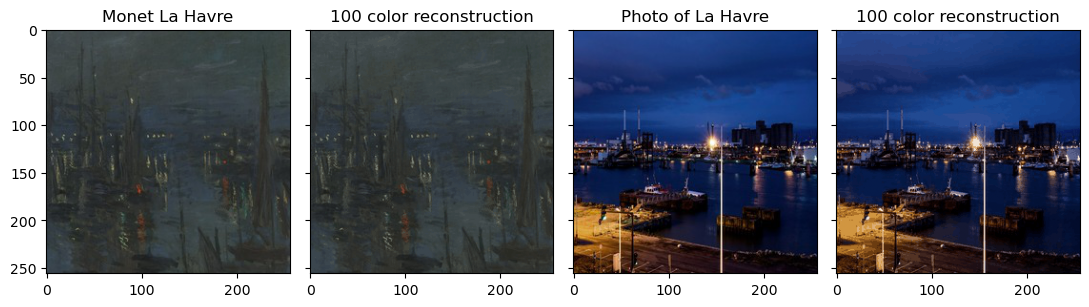

In [36]:
K = 100
X_lahav_photo, CC_lahav_photo, CC_init_lahav_photo, whichCluster_lahav_photo = color_kmeans(photo_lahav, K=100)
X_lahav_painting, CC_lahav_painting, CC_init_lahav_painting, whichCluster_lahav_painting = color_kmeans(painting_lahav, K=100)

f, ax = plt.subplots(1,4, figsize=(11,3), sharex=True, sharey=True)

ax[0].imshow(painting_lahav/255)
ax[0].set_title('Monet La Havre')

# Reconstructed Image.
Ir_lahav_monet = np.reshape(CC_lahav_painting[whichCluster_lahav_painting,:], painting_lahav.shape)
ax[1].imshow(Ir_lahav_monet/255) # Because it's floating point.
ax[1].set_title('{} color reconstruction'.format(K))

ax[2].imshow(photo_lahav/255)
ax[2].set_title('Photo of La Havre')

# Reconstructed Image.
Ir_lahav_photo = np.reshape(CC_lahav_photo[whichCluster_lahav_photo,:], photo_lahav.shape)
ax[3].imshow(Ir_lahav_photo/255) # Because it's floating point.
ax[3].set_title('{} color reconstruction'.format(K))

plt.tight_layout()
plt.show()

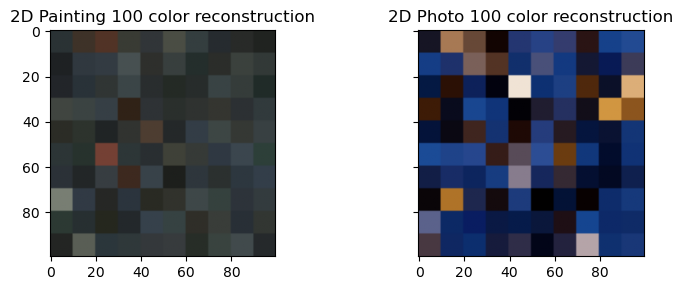

In [39]:
f, ax = plt.subplots(1,2, figsize=(8,3), sharex=True, sharey=True)

havre_painting_100 = np.zeros((100, 100, 3))
havre_photo_100 = np.zeros((100, 100, 3))

havre_painting_100 = transform_image(havre_painting_100, CC_lahav_painting)
havre_photo_100 = transform_image(havre_photo_100, CC_lahav_photo)

ax[0].imshow(havre_painting_100/255)
ax[0].set_title('2D Painting {} color reconstruction'.format(K))

ax[1].imshow(havre_photo_100/255)
ax[1].set_title('2D Photo {} color reconstruction'.format(K))

# plt.figure()
# plt.imshow(test_img/255)
plt.tight_layout()
plt.show()

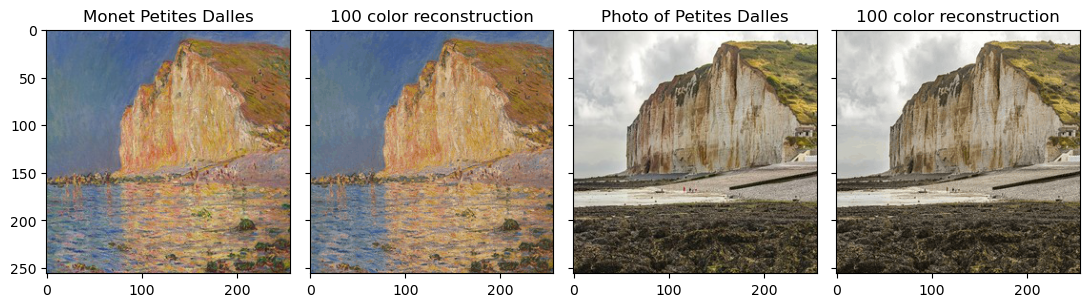

In [37]:
X_petite_painting, CC_petite_painting, CC_init_petite_painting, whichCluster_petite_painting = color_kmeans(painting_petite, K=100)
X_petite_photo, CC_petite_photo, CC_init_petite_photo, whichCluster_petite_photo = color_kmeans(photo_petite, K=100)

f, ax = plt.subplots(1,4, figsize=(11,3), sharex=True, sharey=True)

ax[0].imshow(painting_petite/255)
ax[0].set_title('Monet Petites Dalles')

# Reconstructed Image.
Ir_petite_monet = np.reshape(CC_petite_painting[whichCluster_petite_painting,:], painting_petite.shape)
ax[1].imshow(Ir_petite_monet/255) # Because it's floating point.
ax[1].set_title('{} color reconstruction'.format(K))

ax[2].imshow(photo_petite/255)
ax[2].set_title('Photo of Petites Dalles')

# Reconstructed Image.
Ir_petite_photo = np.reshape(CC_petite_photo[whichCluster_petite_photo,:], photo_petite.shape)
ax[3].imshow(Ir_petite_photo/255) # Because it's floating point.
ax[3].set_title('{} color reconstruction'.format(K))

plt.tight_layout()
plt.show()

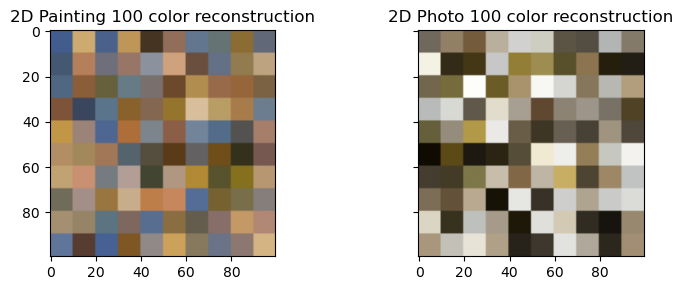

In [43]:
f, ax = plt.subplots(1,2, figsize=(8,3), sharex=True, sharey=True)

petite_painting_100 = np.zeros((100, 100, 3))
petite_photo_100 = np.zeros((100, 100, 3))

petite_painting_100 = transform_image(petite_painting_100, CC_petite_painting)
petite_photo_100 = transform_image(petite_photo_100, CC_petite_photo)

ax[0].imshow(petite_painting_100/255)
ax[0].set_title('2D Painting {} color reconstruction'.format(K))

ax[1].imshow(petite_photo_100/255)
ax[1].set_title('2D Photo {} color reconstruction'.format(K))

# plt.figure()
# plt.imshow(test_img/255)
plt.tight_layout()
plt.show()

**Understanding the 2D Reconstructions**  
We are picking 100 colors from the original painting and the original photo are making new 100x100 images with just those colors. We think that these visualizations make it easier to visually compare just the colors being used in an image, allowing us to ignore what is actually being predicted. For instance with the Petites Dalles, we notice a lot more pinks and blues than in the photo, which has a lot more browns, whites, and blacks. 

## SSIM - Structural Similarity Index  
**SSIM** is a metric used to measure the similarity between two given images. It takes into account the luminance, structure, and contrast of the images in order to draw a comparison. The SSIM score ranges from -1 to 1, where 1 indicates perfect similarity between two images and 0 indicates no similarity, and negative values indicate inverse relationships between images. 

For our purposes and since we are new to image processing, we used the functions we found online to calculate the SSIM for images. We will import the functions from another notebook in this directory (```SSIM_notebook.ipynb```). The link to the original article is below.


https://medium.com/srm-mic/all-about-structural-similarity-index-ssim-theory-code-in-pytorch-6551b455541e#abc2

In [44]:
# Credit to: https://github.com/pranjaldatta/SSIM-PyTorch.git
import torch
import torch.nn.functional as F 
import numpy as np
import math
from PIL import Image
import cv2

def gaussian(window_size, sigma):
    """
    Generates a list of Tensor values drawn from a gaussian distribution with standard
    diviation = sigma and sum of all elements = 1.

    Length of list = window_size
    """    
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):

    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
    
    # Converting to 2D  
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
     
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())

    return window

def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):

    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2
    
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean() 
    else: 
        ret = ssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret

# helper function to load images
load_images = lambda x: np.asarray(Image.open(x).resize((480, 640)))

# Helper functions to convert to Tensors
tensorify = lambda x: torch.Tensor(x.transpose((2, 0, 1))).unsqueeze(0).float().div(255.0)

# display imgs 
def display_imgs(x, transpose=True, resize=True):
  if resize:
    x=cv2.resize(x, (400, 400))
  if transpose:
    cv2.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
  else:
    cv2.imshow(x)

Here are the images we will compare using SSIM:

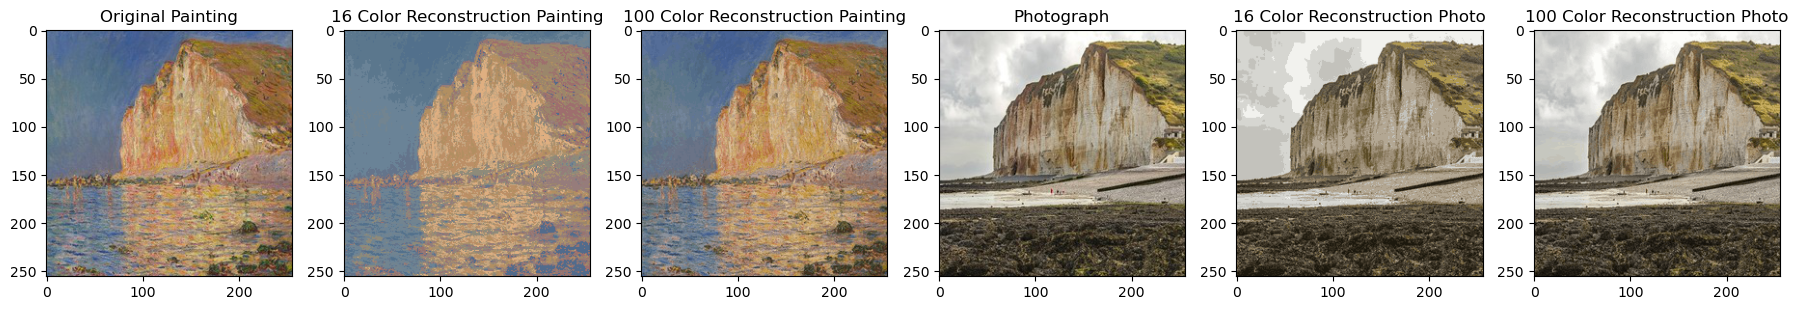

In [45]:
f, axarr = plt.subplots(1,6, figsize=(18, 3))

# Let's compare the Petites Dalles photos and paintings 
X_petite_painting_16, CC_petite_painting_16, CC_init_petite_painting_16, whichCluster_petite_painting_16 = color_kmeans(painting_petite, K=16)
X_petite_photo_16, CC_petite_photo_16, CC_init_petite_photo_16, whichCluster_petite_photo_16 = color_kmeans(photo_petite, K=16)

axarr[0].imshow(painting_petite)
axarr[0].set_title('Original Painting')

Ir_petite_16 = np.reshape(CC_init_petite_painting_16[whichCluster_petite_painting_16,:], painting_petite.shape)
axarr[1].imshow(Ir_petite_16)
axarr[1].set_title('16 Color Reconstruction Painting')

axarr[2].imshow(Ir_petite_monet)
axarr[2].set_title('100 Color Reconstruction Painting')

axarr[3].imshow(photo_petite)
axarr[3].set_title('Photograph')

Ir_petite_photo_16 = np.reshape(CC_petite_photo_16[whichCluster_petite_photo_16,:], photo_petite.shape)
axarr[4].imshow(Ir_petite_photo_16)
axarr[4].set_title('16 Color Reconstruction Photo')

axarr[5].imshow(Ir_petite_photo)
axarr[5].set_title('100 Color Reconstruction Photo')

plt.tight_layout()
plt.show()

In [46]:
# Check SSIM score of Paintings
_img1 = tensorify(painting_petite)
_img2 = tensorify(Ir_petite_16)
_img3 = tensorify(Ir_petite_monet)

_photo1 = tensorify(photo_petite)
_photo2 = tensorify(Ir_petite_photo_16)
_photo3 = tensorify(Ir_petite_photo)

true_vs_16 = ssim(_img1, _img2, val_range=255)
print("Painting vs 16 Color Reconstructioin SSIM Score:", true_vs_16)

true_vs_100 = ssim(_img1, _img3, val_range=255)
print("Painting vs 100 Color Reconstructioin SSIM Score:", true_vs_100)

print()

true_vs_16 = ssim(_photo1, _photo2, val_range=255)
print("Photo vs 16 Color Reconstructioin SSIM Score:", true_vs_16)

true_vs_100 = ssim(_photo1, _photo3, val_range=255)
print("Photo vs 100 Color Reconstructioin SSIM Score:", true_vs_100)

print()

painting_vs_photo = ssim(_img1, _photo1, val_range=255)
print("Original Painting vs Original Photo SSIM Score:", painting_vs_photo)


Painting vs 16 Color Reconstructioin SSIM Score: tensor(0.6928)
Painting vs 100 Color Reconstructioin SSIM Score: tensor(0.9397)

Photo vs 16 Color Reconstructioin SSIM Score: tensor(0.9132)
Photo vs 100 Color Reconstructioin SSIM Score: tensor(0.9823)

Original Painting vs Original Photo SSIM Score: tensor(0.2198)


**Understanding the SSIM results**  
As we increase the amount of colors we use to reconstruct the painting, we notice an increase in SSIM, since the images are using more and more of the same colors. The same happens for the photo. But, the photo reconstructions start off more similar (0.91) than the painting reconstructions (0.69). This may be because Monet uses a lot more shades of a similar color in this painting than the photo captures. Even just visually, the 16 color and the original photo look much more similar than the 16 color and the original painting. Using our modeling techniques, we hope to increase the SSIM score between the original painting and the original photo (0.2198). We will repeat this process for all of the matching paintings and location photos we've collected.

---

## Modeling

---

## Performance Results

In [ ]:
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
 
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid
 
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# define two fake collections of images
images1 = randint(0, 255, 10*32*32*3)
images1 = images1.reshape((10,32,32,3))
images2 = randint(0, 255, 10*32*32*3)
images2 = images2.reshape((10,32,32,3))
print('Prepared', images1.shape, images2.shape)

# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')

# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)

# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

2024-04-30 14:45:26.959378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


87910968/87910968 [==============================] - 7s 0us/step
Prepared (10, 32, 32, 3) (10, 32, 32, 3)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
1/1 [==============================] - 1s 734ms/step
FID (same): -9317572888464604258818749925073879836401933862876301230080.000
1/1 [==============================] - 1s 771ms/step
FID (different): 5358672842709649172869949453619531477490844540783300746840967902977418160923620643152340210664348527149701406681726976.000


In [ ]:
import os
from PIL import Image

# Function to load images from a folder
def load_images_from_folder(folder_path, size):
    images = []
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        try:
            # Load image
            image = Image.open(filepath)
            # Resize image
            image = image.resize(size)
            # Convert to numpy array
            image = asarray(image)
            # Store image and file path
            images.append((image, filepath))
        except:
            # Skip if unable to load or process the image
            continue
    return images

# Define folder paths for two datasets
folder_path1 = "data/photo_jpg/"
folder_path2 = "data/monet_jpg/"

# Load images from folders
images1 = load_images_from_folder(folder_path1, (299, 299))
images2 = load_images_from_folder(folder_path2, (299, 299))
print('Loaded', len(images1), 'images from folder 1')
print('Loaded', len(images2), 'images from folder 2')

# Extract images and file paths
images1, file_paths1 = zip(*images1)
images2, file_paths2 = zip(*images2)

# Convert images to numpy arrays
images1 = asarray(images1)
images2 = asarray(images2)

# Convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')

# Pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

# FID between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# FID between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)


Loaded 7038 images from folder 1
Loaded 299 images from folder 2
220/220 [==============================] - 529s 2s/step
FID (same): -0.000
10/10 [==============================] - 23s 2s/step
FID (different): 5601848934919836737238225643125789942891538082581324689249386235724548574349175942004342784.000


---

## Discussion  



--- 

## Conclusions